In [13]:
from pathlib import Path
import pickle
import numpy as np
from constants import KINECT_JOINT_NAMES, KINECT_KPT_DIMS, BODY8_JOINT_NAMES, BODY8_KPT_DIMS
from parsers import parse_poses3d, parse_poses2d
from plot_utils import plot_pc_2d_planes, plot_pc_3d, plot_pc_2d_pose
root = Path("data")
subject = "19_MM"

with open(root / f"{subject}.pickle", 'rb') as handle:
    data = pickle.load(handle)
print(f"Total frames for {subject}: {len(data)}")

Total frames for 19_MM: 33955


In [19]:
sample_frame = 1000
frame = data[sample_frame]
print(f"Datatypes: {list(frame.keys())}")

Datatypes: ['poses3d', 'poses2d', 'num_people', 'pc', 'wallclock']


'wallclock' is a unique identifier for all frame, associating each captured frame with an absolute datetime

In [20]:
print(f"Global datetime of frame: {frame['wallclock']}")

Global datetime of frame: 2024-01-15 09:49:19.243666


The pose estimation algorithms used to obtain the pose ground truth are not perfect. Sometimes they would miss people entirely or detect people that don't exist. The number of people in each frame was manually labelled:

In [21]:
print(f"True number of people in the frame: {frame['num_people']}")

True number of people in the frame: 1.0


'poses3d' contains 3D pose ground truth from the Kinect camera.

In [22]:
print(frame['poses3d'].shape)
num_poses_3d = frame['poses3d'].shape[0]
print(f"Number of poses detected by kinect: {num_poses_3d}")
poses3d = parse_poses3d(frame['poses3d'])
if poses3d is not None:
    #inspect first pose
    pose = poses3d[0]
    print(f"Number of kinect keypoints: {pose.shape[0]}\n")
    # x_coordinates = pose[:,0]
    # y_coordinates = pose[:,1]
    # z_coordinates = pose[:,2]
    # confidence_scores = pose[:,3]

(128,)
Number of poses detected by kinect: 128
Number of kinect keypoints: 32



'poses2d' contains 2D pose ground truth from RTM-pose applied to the RGB video captured by the Kinect. They are more reliable than poses3d but lack depth information.

In [24]:
print(frame['poses2d'].shape)
num_poses = frame['poses2d'].shape[0]
print(f"number of poses detected by 2D HPE model: {num_poses}")
poses2d, bbox_scores = parse_poses2d(frame['poses2d'])
if poses2d is not None:
    print(f"bounding box scores: {bbox_scores}")
    #inspect first pose
    pose = poses2d[0]
    print(f"Number of 2D keypoints: {pose.shape[0]}\n")
    # x_coordinates = pose[:,0]
    # y_coordinates = pose[:,1]
    # confidence_scores = pose[:,2]

(79,)
number of poses detected by 2D HPE model: 79


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

'pc' contains unfiltered mmWave radar point cloud. The GTRACK algorithm was applied to this data to identify noisy points. GTRACK associated each point with a target id to help filter out noise:
* 0-252  not noise, target detected as a person with identification number 0-252 
* 253    noise, signal to noise ratio is too week 
* 254    noise, located outside of the physical room boundary
* 255    noise, target not associated as a person

In [26]:
from constants import OOB_TID, NOISE_TARGET_IDS

pc = frame['pc']
print(pc.shape)
num_points = pc.shape[0]
print(f"Number of radar points: {num_points}")
# x_coordinates = pc[:,0]
# y_coordinates = pc[:,1]
# z_coordinates = pc[:,2]
# doppler_values = pc[:,3]
# signal_to_noise_ratios = pc[:,4]
target_ids = pc[:,5]

n_out_of_bounds = np.count_nonzero(target_ids == 255)
n_noise = np.count_nonzero(np.isin(target_ids, NOISE_TARGET_IDS))
n_not_noise = np.count_nonzero(~np.isin(target_ids, NOISE_TARGET_IDS))
print(f"This frame has {n_noise} noisy points and {n_not_noise} non-noisy points")
print(f"{n_out_of_bounds} of the noisy points are considered noise because they are out of bounds")

(489, 6)
Number of radar points: 489
This frame has 276 noisy points and 213 non-noisy points
77 of the noisy points are considered noise because they are out of bounds


## Visualization

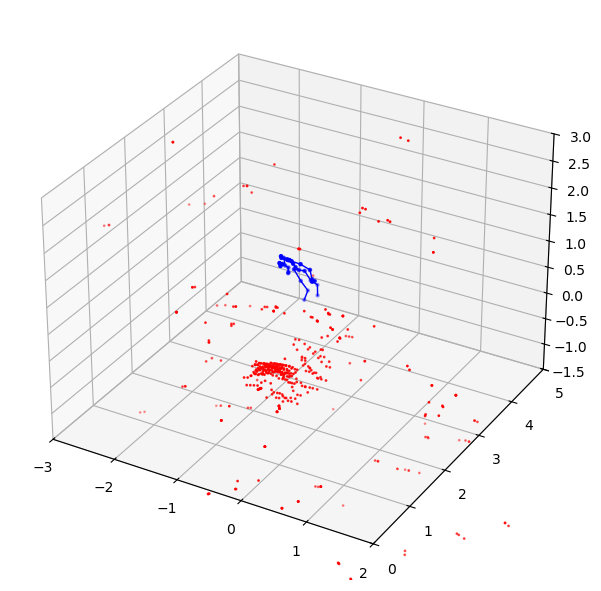

In [27]:
plot_pc_3d(pc, poses3d)
#show out of bound points too:
#plot_pc_3d(pc, poses3d, bounless=True)

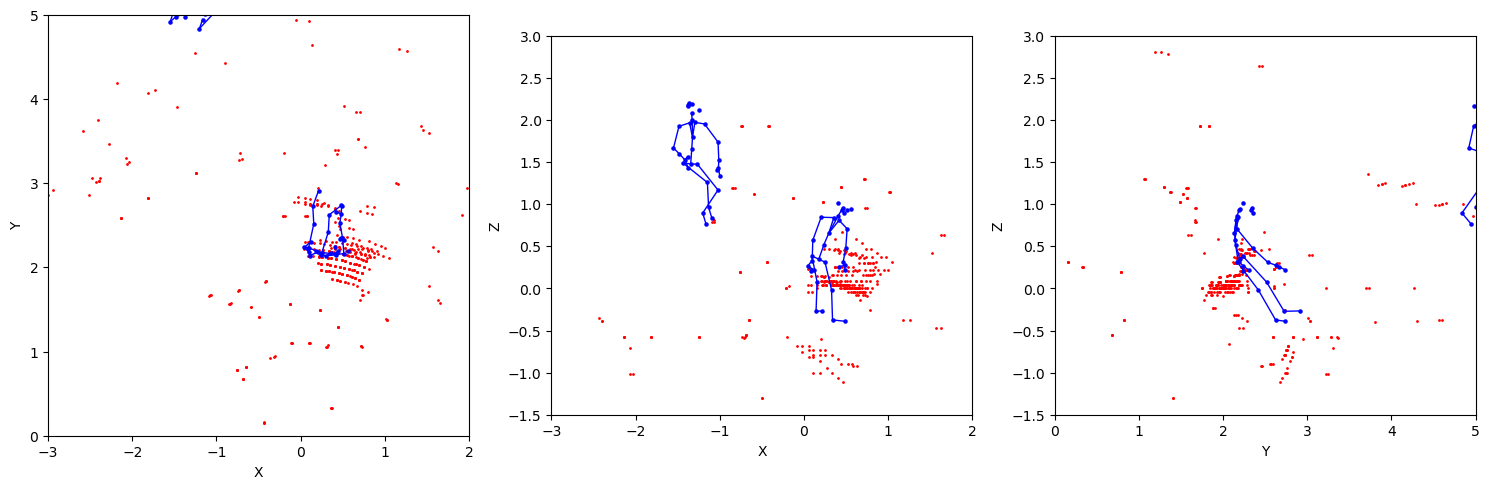

In [83]:
plot_pc_2d_planes(pc, poses3d)
#show out of bound points too:
#plot_pc_2d_planes(pc, poses3d, boundless=True)

## Coordinate Systems

* Point cloud is projected in the 'radar frame of reference' - which is defined by a coordinate system where the origin is the radar antennas, X axis runs horizontally accross the radar (left is negative), the Y axis is perpendicular to the radar surface (representing depth) and the Z axis runs vertically accross the radar (up is positive). Point cloud coordinates are expressed in metres. `plot_pc_2d_planes` and `plot_pc_3d` visualize data in the radar coordinate system.

* 3D pose is projected in the 'Kinect frame of reference' - which is defined by a coordinate system where the origin is the Kinect camera, X axis is same as radar, the Y axis runs vertically accross the Kinect (down is positive) and Z axis is perpendicular to the camera. Kinect coordinates are expressed in millimetres. `_3d_pose_to_pc` in transformations.py transforms 3D pose to the radar coordinate system.

* 2D pose is projected in the 'Digital frame of reference' - which is defined by a coordinate system where the origin is the corner of the digital RGB image from the Kinect camera recording. Coordinates are expressed in pixels. `_3d_to_digital` can be used to convert Kinect coordinates to the digital frame of reference. This is only for visualization purposes. We can apply this to point cloud if we represent point cloud in kinect coordinates. `plot_pc_2d_pose` can plot point cloud, 2D and 3D pose in the digital coordinate system.

In [25]:
#plot_pc_2d_pose(pc, poses2d=poses2d, poses3d=poses3d)
plot_pc_2d_pose(pc, poses2d=poses2d)
#show out of bound points too:
#plot_pc_2d_pose(pc, poses2d=poses2d, boundless=True)

NameError: name 'pc' is not defined